In [1]:
import os
os.chdir('../../')

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
from models import cmlp
from utilities import fits
from flax import linen as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from utilities.plot import plot_binary_class,plot_train_test
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
from jax.flatten_util import ravel_pytree
import blackjax
from probml_utils.blackjax_utils import inference_loop
from sklearn.calibration import calibration_curve,CalibrationDisplay

2022-06-30 15:27:44.073707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


# Dataset Visualization

In [32]:
X,Y =  datasets.make_moons(400, noise=0.20,random_state=6)

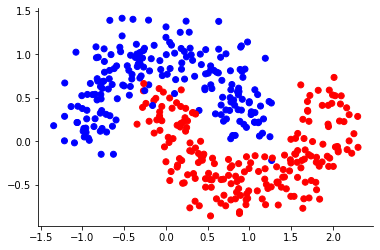

In [33]:
plt.scatter(X[:,0],X[:,1],c=Y,cmap="bwr")
sns.despine()

In [34]:
h=0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))

In [35]:
xx.shape

(214, 283)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=45)

In [37]:
X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)


# Single MLP

In [38]:
model = cmlp.cmlp([8,16,32,16,8,1],[nn.relu,nn.relu,nn.relu,nn.relu,nn.relu],[0.03]*5)

In [39]:
auxs = {
    "X" : X_train,
    "y" : y_train,
    "deterministic": True,
}

## Train

In [40]:
seed=0
params = model.init(jax.random.PRNGKey(seed), X_train, deterministic = True)
params, loss =  fits.fit(model, params,X_train,y_train,True,learning_rate=0.01, epochs=1000,batch_size=64)

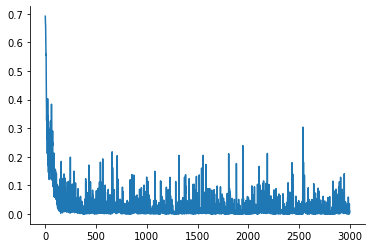

In [41]:
plt.plot(jnp.arange(0,loss.shape[0],1),loss)
sns.despine()

In [42]:
y_pred_train = model.apply(params, X_train, deterministic=True)
y_pred_test = model.apply(params, X_test, deterministic=True)

In [43]:
def plot_caliberation(pred_train,pred_test,title):
    fig,ax1 = plt.subplots(1,1)
    prob_true_train,prob_pred_train = calibration_curve(y_train,pred_train,n_bins=5)
    prob_true_test,prob_pred_test = calibration_curve(y_test,pred_test)

    disp_train = CalibrationDisplay(prob_true_train,prob_pred_train,pred_train,estimator_name="Train")
    disp_test = CalibrationDisplay(prob_true_test,prob_pred_test,pred_test,estimator_name="Test")

    disp_train.plot(ax=ax1)
    disp_test.plot(ax=ax1)
    sns.despine(ax=ax1)
    ax1.legend(loc=0)
    ax1.set_title(title)

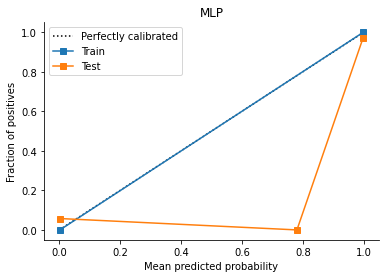

In [44]:
mlp_pred_train = model.apply(params,X_train,deterministic=True).reshape(y_train.shape)
mlp_pred_test = model.apply(params,X_test,deterministic=True).reshape(y_test.shape)
plot_caliberation(mlp_pred_train,mlp_pred_test,"MLP")
plt.savefig("MLP_caliberation.pdf")

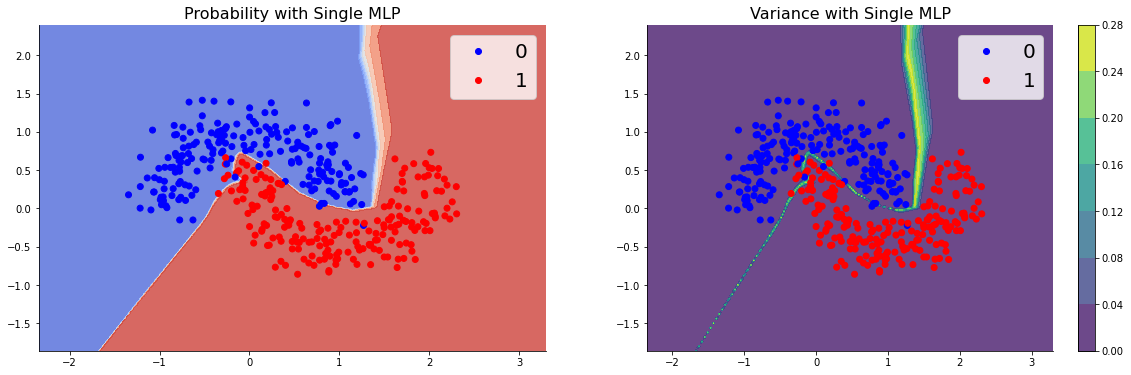

In [45]:
p =model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True).reshape(xx.shape)
var = p*(1-p).reshape(xx.shape)

plot_binary_class(X,Y,xx,yy,p,var,titles=("Probability with Single MLP","Variance with Single MLP"))
# plt.savefig("figures/mlp_moons.pdf")
plt.savefig("MLP_moons.pdf")

# Deep Ensemble

In [46]:
params_lst= []
loss_lst =[]
for i in range(5):
    params =  model.init(jax.random.PRNGKey(i),X,deterministic=True)
    params,loss = fits.fit(model, params,X_train,y_train,True,learning_rate=0.01, epochs=100)
    params_lst.append(params)
    loss_lst.append(loss)

In [47]:
p_de_train_ensemble = []
p_de_test_ensemble = []

for i in range(5):
    params = params_lst[i]
    p =model.apply(params,X_train,deterministic=True)
    p_de_train_ensemble.append(p)
    p =model.apply(params,X_test,deterministic=True)
    p_de_test_ensemble.append(p)
ensemble_pred_train = jnp.array(p_de_train_ensemble).mean(axis=0).reshape(y_train.shape)
ensemble_pred_test= jnp.array(p_de_test_ensemble).mean(axis=0).reshape(y_test.shape)

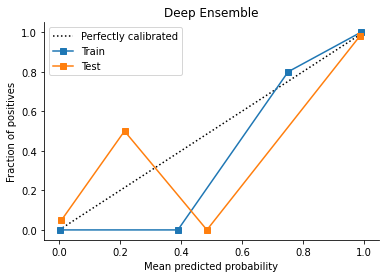

In [48]:
plot_caliberation(ensemble_pred_train,ensemble_pred_test,title="Deep Ensemble")
plt.savefig("Deep Ensemble caliberation.pdf")

In [49]:
p_grid_ensemble = []

for i in range(5):
    params = params_lst[i]
    p =  model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True).reshape(xx.shape)
    p_grid_ensemble.append(p)
ensemble_p_mean = jnp.array(p_grid_ensemble).mean(axis=0)
ensemble_p_sigma =  jnp.array(p_grid_ensemble).std(axis=0)
# ensemble_p_sigma = ensemble_p_mean*(1-ensemble_p_mean)


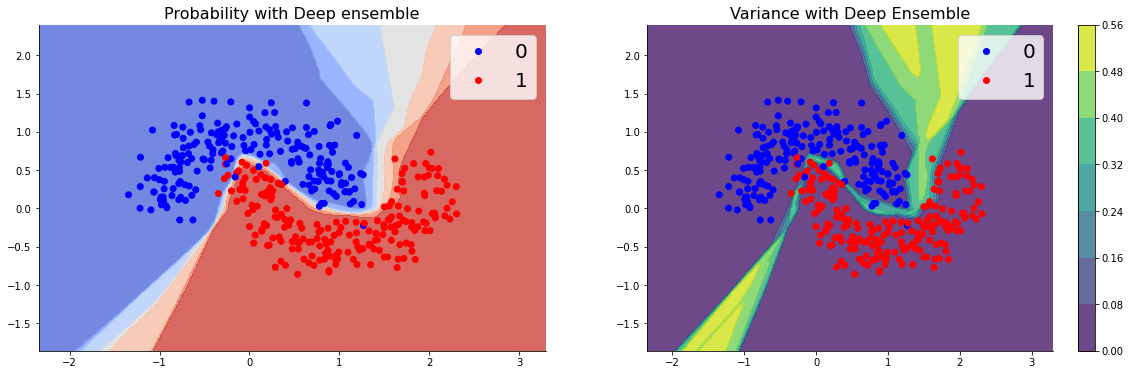

In [50]:
plot_binary_class(X,Y,xx,yy,ensemble_p_mean,ensemble_p_sigma,titles=("Probability with Deep ensemble","Variance with Deep Ensemble"))
plt.savefig("Deep Ensemble Moons.pdf")

### MC Dropout

In [51]:
y_stacks = []

@jax.jit
def func(params, i):
    z = model.apply(params, jnp.c_[xx.ravel(), yy.ravel()], deterministic=False, 
                    rngs={"dropout": jax.random.PRNGKey(i)}).reshape(xx.shape)
    return z
y_stacks = jax.vmap(fun=func, in_axes=(None, 0))(params, jnp.arange(50))

In [52]:
mc_pred_mean= jnp.array(y_stacks).mean(axis=0).reshape(xx.shape)
mc_pred_sigma = (jnp.array(y_stacks).std(axis=0)).reshape(yy.shape)

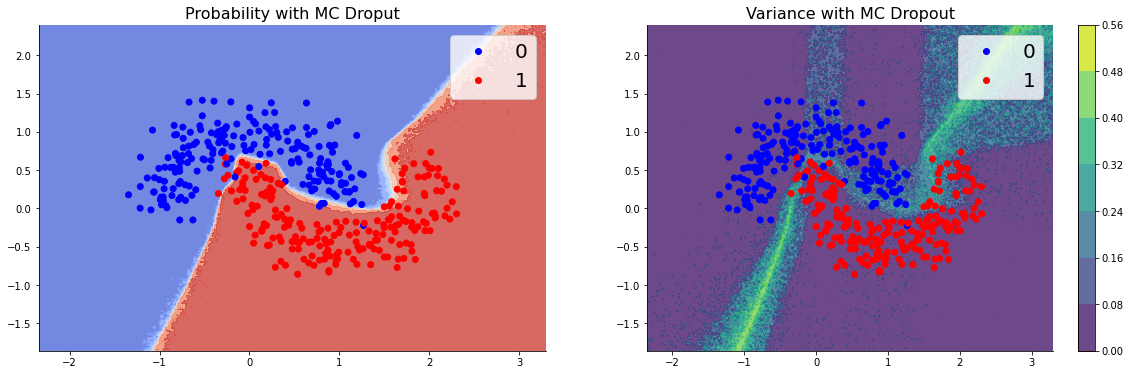

In [53]:
plot_binary_class(X,Y,xx,yy,mc_pred_mean,mc_pred_sigma,titles=("Probability with MC Droput","Variance with MC Dropout"))
plt.savefig("MC Dropout Moons.pdf")

In [54]:
y_stacks_train = []
y_stacks_test = []


def create_apply_func(X_test):
    def func(params, i):
        z = model.apply(params, X_test, deterministic=False, 
                        rngs={"dropout": jax.random.PRNGKey(i)})
        return z
    return func
y_stacks_train = jax.vmap(fun=create_apply_func(X_train), in_axes=(None, 0))(params, jnp.arange(50))
y_stacks_test = jax.vmap(fun=create_apply_func(X_test), in_axes=(None, 0))(params, jnp.arange(50))


In [55]:
mc_pred_train = y_stacks_train.mean(axis=0)
mc_pred_test = y_stacks_test.mean(axis=0)

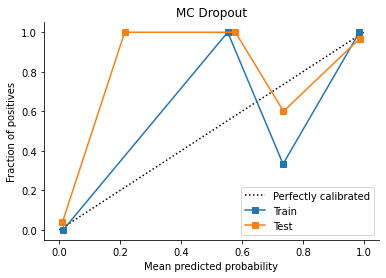

In [56]:
plot_caliberation(mc_pred_train,mc_pred_test,"MC Dropout")
plt.savefig("MC_dropout_caliberation.pdf")

# NUTS

In [57]:
def bnn_log_joint(params:dict, X, y, model):
    """
    computes the numerator term of the posterior funtion.

    params: dictionary initalized by model 
    X: shape-(n_samples,2) training points 
    y: shape-(n_samples,) labels for training points
    model: bnn model
    """
    
    logits = model.apply(params, X,deterministic=True).ravel()
    
    flatten_params, _ = ravel_pytree(params)
    log_prior = tfd.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = tfd.Bernoulli(logits=logits).log_prob(y).sum()
    log_joint = log_prior + log_likelihood
    return log_joint

bnn_log_joint_partial =partial(bnn_log_joint,X=X,y=Y,model=model)
bnn_log_joint_partial(params)

DeviceArray(-1594.4712, dtype=float32)

In [58]:
from pandas import read_pickle
states,infos = read_pickle("MCMC.pkl")['states'],read_pickle("MCMC.pkl")['infos']

In [59]:
num_warmup = 1000
potential = bnn_log_joint_partial
key = jax.random.PRNGKey(314)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)
adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params)
num_samples = 500
states,infos = inference_loop(key_samples, kernel, final_state, num_samples)

In [60]:
seed = jax.random.PRNGKey(0)

def predict_mcmc(x_test):
    def one_step(carry, state):
        params_cur = state.position
        samples = tfd.Bernoulli(probs=model.apply(params_cur,x_test,deterministic=True)).sample(seed=seed)
        return carry, samples
    _, y_stacks = jax.lax.scan(one_step, None, states)
    mean = y_stacks.mean(axis=0)
    std_dev = y_stacks.std(axis=0) 
    return mean,std_dev

mcmc_pred_mean,mcmc_pred_sigma = predict_mcmc(jnp.c_[xx.ravel(), yy.ravel()])
mcmc_pred_mean,mcmc_pred_sigma = mcmc_pred_mean.reshape(xx.shape),mcmc_pred_sigma.reshape(xx.shape)

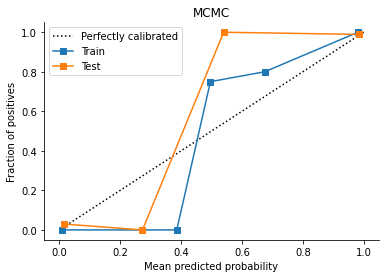

In [61]:
mcmc_pred_train, _= predict_mcmc(X_train)
mcmc_pred_test,_ = predict_mcmc(X_test)
plot_caliberation(mcmc_pred_train,mcmc_pred_test,"MCMC")
plt.savefig("MCMC_caliberation.pdf")

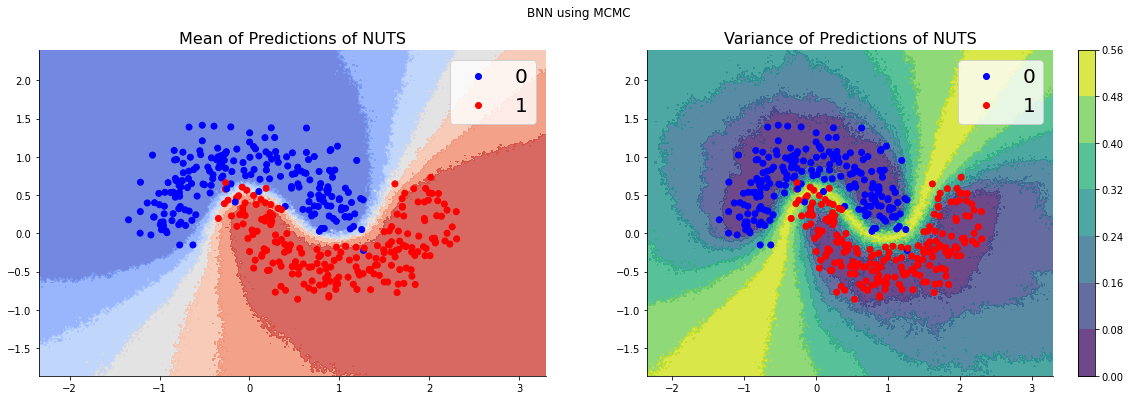

In [62]:
titles_mcmc = ("Mean of Predictions of NUTS","Variance of Predictions of NUTS")
plot_binary_class(X_scatters=X,y_scatters=Y,XX1_grid=xx,
XX2_grid = yy,grid_preds_mean=mcmc_pred_mean,grid_preds_sigma= mcmc_pred_sigma,titles=titles_mcmc)
plt.suptitle("BNN using MCMC")
plt.savefig("MCMC_moons.pdf")

# GP


Name : gp_classification
Objective : 54.70258268361931
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |        
-54.70258268361931


Optimization restart 1/5, f = 27.04100009467801
Optimization restart 2/5, f = 47.03799663262887
Optimization restart 3/5, f = 43.018939202030225
Optimization restart 4/5, f = 55.216260687797
Optimization restart 5/5, f = 36.76186776836485

Name : gp_classification
Objective : 39.528795008786176
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |  10.343392749437063  |      +ve      |        
  rbf.lengthscale     |  0.6717031475178565  |      +ve      |        


 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


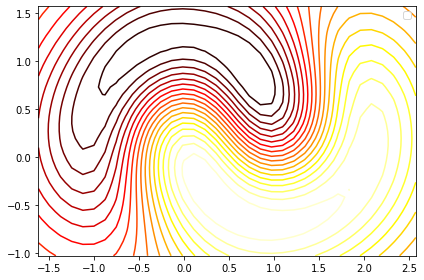

In [63]:
import GPy
import numpy as np
h=0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))

model = GPy.models.GPClassification(np.array(X_train), np.array(y_train.reshape(-1,1)))
print(model)
print(model.log_likelihood())
model.optimize(messages=True)
model.optimize_restarts(num_restarts=5)
print(model)
model.plot_f()
probability_gp,na = model.predict(jnp.c_[xx.ravel(), yy.ravel()])

In [64]:
probability_gp = probability_gp.reshape(xx.shape)
sigma_gp = jnp.sqrt(probability_gp*(1-probability_gp)).reshape(xx.shape)


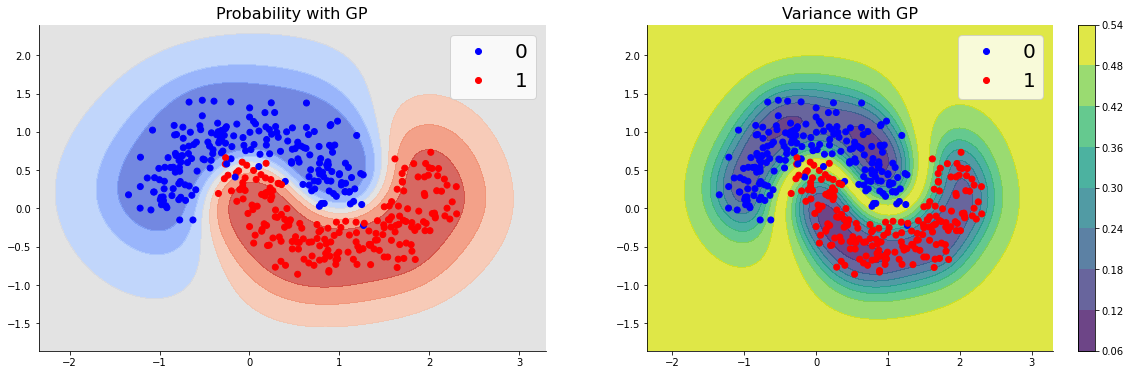

In [65]:
plot_binary_class(X,Y,xx,yy,probability_gp,sigma_gp,titles=("Probability with GP","Variance with GP"))
plt.savefig("GP moons.pdf")

 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


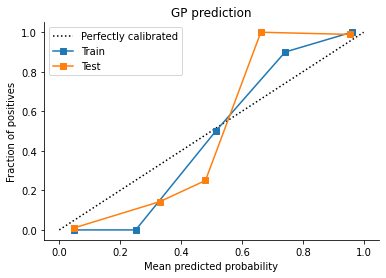

In [66]:
gp_pred_train,na = model.predict(X_train)
gp_pred_test, na = model.predict(X_test)
plot_caliberation(gp_pred_train,gp_pred_test,"GP prediction")
plt.savefig("GP_caliberation.pdf")